# Recommendations with IBM

Analyzes the interactions that users have with articles on the [IBM Watson Studio platform](https://www.ibm.com/cloud/watson-studio), and makes recommendations to them about new articles they might like. 

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (TODO)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

`1.` What is the distribution of how many articles a user interacts with in the dataset?
Provides a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
user_article = df["email"].value_counts() 
user_article.head()

2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
Name: email, dtype: int64

In [4]:
user_article.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: email, dtype: float64

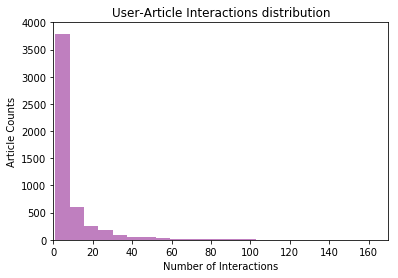

In [5]:
# Distribution 

plt.hist(user_article, bins=50, alpha=.5, color='purple', density=False);
plt.axis([0, 170,0, 4000])
plt.xlabel('Number of Interactions');
plt.ylabel('Article Counts')
plt.title('User-Article Interactions distribution');
plt.show()

In [6]:
# Median and maximum number of user_article interactios

median_val = np.median(user_article)
max_views_by_user = np.max(user_article)
print("50% of individuals interact with {} of articles or fewer.".format(int(median_val)))
print("The maximum number of user-article interactions by any 1 user is {}.".format(max_views_by_user))

50% of individuals interact with 3 of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [7]:
df_content.shape

(1056, 5)

In [8]:
# Find and explore duplicate articles
df_content.duplicated(['article_id']).sum()

5

In [9]:
df_cont_dupl = np.where(df_content.duplicated(['article_id']) == True)

print("Duplicated Articles:\n")
for i in df_cont_dupl[0]:
    print(i, df_content[df_content['article_id'] == i]['doc_full_name'].values)

Duplicated Articles:

365 ["Go Serverless with Apex and Compose's MongoDB"]
692 ['15 Page Tutorial for R']
761 ['Variational auto-encoder for "Frey faces" using keras']
970 ['Launching RESTHeart into Production']
971 ['Defensive coding in Map/Index functions']


In [10]:
# Remove any rows that have the same article_id and only keep the first
df_content = df_content.drop_duplicates(subset='article_id', keep='first')
df_content.shape

(1051, 5)

`3.` In the following cells I search for:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [11]:
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [12]:
df.shape[0]

45993

In [13]:
# Interactions data
df.nunique()

article_id     714
title          714
email         5148
dtype: int64

In [14]:
# IBM platform content data
df_content.nunique()

doc_body           1031
doc_description    1019
doc_full_name      1051
doc_status            1
article_id         1051
dtype: int64

In [15]:
# The number of unique articles that have at least one interaction
unique_articles = df.nunique().article_id

# The number of unique articles on the IBM platform
total_articles = df_content.nunique().article_id

# The number of unique users
unique_users = df.nunique().email

# The number of user-article interactions
user_article_interactions = df.shape[0]

`4.` In the following cells, I search for the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [16]:
df_most_viewed = df.groupby(['article_id']).count()
df_most_viewed['email'].max()

937

In [17]:
df_most_viewed['email'].idxmax()

1429.0

In [18]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str(df_most_viewed['email'].idxmax())

# The most viewed article in the dataset was viewed how many times?
max_views = df_most_viewed['email'].max()

In [19]:
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [20]:
# Results check

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

We don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Return the **n** top articles ordered with most interactions as the top and test function.

In [21]:
df['article_id'].value_counts().head(10)

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
1314.0    614
1293.0    572
1170.0    565
1162.0    512
1304.0    483
Name: article_id, dtype: int64

In [22]:
df['title'].value_counts().head(10)

use deep learning for image classification                            937
insights from new york car accident reports                           927
visualize car data with brunel                                        671
use xgboost, scikit-learn & ibm watson machine learning apis          643
predicting churn with the spss random tree algorithm                  627
healthcare python streaming application demo                          614
finding optimal locations of new store using decision optimization    572
apache spark lab, part 1: basic concepts                              565
analyze energy consumption in buildings                               512
gosales transactions for logistic regression model                    483
Name: title, dtype: int64

In [23]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df["title"].value_counts().head(n).index)
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df['article_id'].value_counts().head(n).index.astype(str))
 
    return top_articles # Return the top article ids

In [24]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [25]:
# Test function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of the three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Test to make sure the basic structure of the matrix matches what is expected.

In [26]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [27]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item = df.groupby(["user_id", "article_id"])["title"].max().unstack()
    user_item = user_item.notnull().astype(int)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [28]:
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
unique_users, unique_articles

(5148, 714)

In [30]:
user_item.shape

(5149, 714)

In [31]:
# Tests
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` The function `find_similar_users(user_id, user_item=user_item)` takes a user_id and provides an ordered list of the most similar users to that user (from most similar to least similar).  The returned result does not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Test the function.

In [32]:
user_id = 3933
similarity = user_item.loc[user_id, :].dot(user_item.T)
similarity = similarity.sort_values(ascending=False)
similarity.head()

user_id
1       35
3933    35
23      17
3782    17
4459    15
Name: 3933, dtype: int64

In [33]:
most_similar_users = list(similarity.index.values)
most_similar_users.remove(user_id) 
most_similar_users[:5]

[1, 23, 3782, 4459, 203]

In [34]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarity = user_item.loc[user_id, :].dot(user_item.T)

    # sort by similarity
    similarity = similarity.sort_values(ascending=False)

    # create list of just the ids
    most_similar_users = list(similarity.index.values)
    
    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [35]:
# Spot check of the function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Use these users to find articles to recommend.  The functions below return the articles to recommend to each user. 

In [36]:
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
user_id = 3
user_idx = user_item.loc[user_id]
user_idx[user_idx == 1].index.values


array([   12.,    20.,    29.,    43.,    50.,    62.,   109.,   116.,
         120.,   193.,   213.,   381.,   681.,   720.,   721.,   735.,
         784.,   788.,   868.,   957.,   977.,  1035.,  1057.,  1059.,
        1165.,  1172.,  1192.,  1225.,  1271.,  1293.,  1314.,  1330.,
        1343.,  1351.,  1360.,  1397.,  1429.,  1431.,  1432.,  1436.])

In [38]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    article_names = list(df[df["article_id"].isin(article_ids)]["title"].unique())
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    user_idx = user_item.loc[user_id]
    article_ids = list(user_idx[user_idx == 1].index.values.astype('str'))
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # List of users ordered based on closeness to user_id
    most_similar_users = find_similar_users(user_id)
    
    # List of article ids seen by user_id
    user_articles_seen = get_user_articles(user_id)[0]
    
    recs = []
    for neighbor_user in most_similar_users:
        neighbor_articles_seen = set(get_user_articles(neighbor_user)[0])
        recs += list(set(neighbor_articles_seen) - set(user_articles_seen))
        if len(recs) > m:
            break
    
    recs = recs[:m]
    
    return recs # return your recommendations for this user_id    

In [39]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['healthcare python streaming application demo',
 'analyze energy consumption in buildings',
 'use sql with data in hadoop python',
 'modeling energy usage in new york city',
 'brunel interactive visualizations in jupyter notebooks',
 'flightpredict ii: the sequel  – ibm watson data lab',
 'web picks (week of 4 september 2017)',
 'overlapping co-cluster recommendation algorithm (ocular)',
 'perform sentiment analysis with lstms, using tensorflow',
 'small steps to tensorflow']

In [40]:
# Test functions
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the `user_user_recs` function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - we choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, we choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be what would be obtained from the `top_articles` function above.

In [41]:
user_id = 3
# compute similarity of each user to the provided user
similarity = user_item.loc[user_id, :].dot(user_item.T)

# sort by similarity
similarity = pd.DataFrame(similarity.sort_values(ascending=False))
similarity = similarity.reset_index()
similarity.columns = ['user_id', 'similarity']
similarity = similarity[similarity.user_id != user_id]
similarity.head()


,user_id,similarity
1,3353,40
2,3782,23
3,23,23
4,98,17
5,3764,17


In [42]:
similarity = user_item[user_item.index == user_id].dot(user_item.loc[user_id].T).values[0]
similarity

40

In [43]:
num_interactions = user_item.loc[user_id].values.sum()
num_interactions

40

In [44]:
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
user_interactions = df.groupby(["user_id"])["article_id"].count()
user_interactions.head()

user_id
1    47
2     6
3    82
4    45
5     5
Name: article_id, dtype: int64

In [46]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    neighbors_ids = user_item.index.values[user_item.index.values != user_id]
    similarity = []
    interactions = df.groupby(["user_id"])["article_id"].count()
    num_interactions = []

    for id in neighbors_ids:
        similarity.append(np.dot(user_item.loc[user_id],user_item.loc[id]))
        num_interactions.append(interactions.loc[id])
    
    # create dataframe
    neighbors_df = pd.DataFrame({"neighbor_id": neighbors_ids, 
                                 "similarity": similarity,
                                 "num_interactions": num_interactions})
    neighbors_df = neighbors_df.sort_values(by = ['similarity', 'neighbor_id'], ascending = [False, True])
    
       
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    
    # Dataframe of closest users ordered by similarity and number of interactions
    neighbors_df = get_top_sorted_users(user_id)
    top_m_neighbor_ids = neighbors_df[:m]['neighbor_id'].tolist()
    
    # List of article ids seen by user_id
    user_articles_seen = get_user_articles(user_id)[0]
    
    recs = []
    for neighbor_user in top_m_neighbor_ids:
        neighbor_articles_seen = set(get_user_articles(neighbor_user)[0])
        recs += list(set(neighbor_articles_seen) - set(user_articles_seen))
        if len(recs) > m:
            break
    
    recs = recs[:m]
    rec_names = list(set(df[df["article_id"].isin(recs)]["title"]))
    
    return recs, rec_names

In [47]:
get_top_sorted_users(3).head()

,neighbor_id,similarity,num_interactions
3351,3353,40,80
21,23,23,364
3780,3782,23,363
96,98,17,170
3762,3764,17,169


In [48]:
# Quick spot check
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['43.0', '1162.0', '684.0', '1314.0', '939.0', '1330.0', '164.0', '1181.0', '1357.0', '1366.0']

The top 10 recommendations for user 20 are the following article names:
['analyze energy consumption in buildings', 'insights from new york car accident reports', 'flexdashboard: interactive dashboards for r', 'deep learning with tensorflow course by big data university', 'learn tensorflow and deep learning together and now!', 'healthcare python streaming application demo', 'car performance data', 'deep learning from scratch i: computational graphs', 'process events from the watson iot platform in a streams python application', 'overlapping co-cluster recommendation algorithm (ocular)']


`5.` Check functions by filling in the solutions to the dictionary below. Test dictionary against the solution.  

In [49]:
user1_most_sim = get_top_sorted_users(1)
user1_most_sim = user1_most_sim['neighbor_id'].values[0]
user1_most_sim

3933

In [50]:
get_top_sorted_users(1).iloc[0].neighbor_id

3933

In [51]:
find_similar_users(1)[0]

3933

In [52]:
get_top_sorted_users(131).iloc[9].neighbor_id

242

In [53]:
find_similar_users(131)[9]

242

In [54]:
# Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0].neighbor_id# Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9].neighbor_id# Find the 10th most similar user to user 131

In [55]:
# Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**In this case, collaborative flitering is not helpful as a technique to make predictions as we don't have any information on the interactions of the user, known as the Cold Start Problem. Therefore we will use rank based recommendations for the new users, defined in the Part II of this notebook as `get_top_articles()`**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [56]:
new_user = '0.0'

# As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to this new user '0.0'
new_user_recs = get_top_article_ids(10)# Your recommendations here
new_user_recs

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [57]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (TODO)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term. Content could be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Create a content based recommender. The input values are currently set with one idea in mind. One additional idea would be to choose the most popular recommendations that meet the 'content criteria', but again, there is a lot of flexibility in how to make these recommendations.

In [58]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Summary explaining how the content based recommender works. Possible improvements that could be made to the function?  Is there anything novel about the content based recommender?

`3.` Use the content-recommendation system to make recommendations for the below scenarios based on the comments. 


In [59]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

Build and use a matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` We have already created a **user_item** matrix above in **question 1** of **Part III** above:

In [60]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [61]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [62]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

**We see that we have no problem performing the SVD as we have no missing values. Here we don't have ratings, but a boolean matrix of whether the user has interacted with the item or not**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

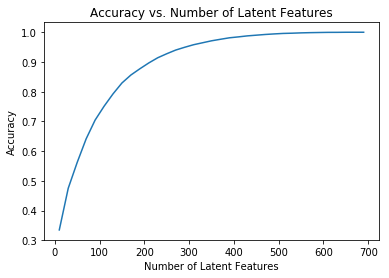

In [63]:
def plot_accuracy(u,s,vt):
    num_latent_feats = np.arange(10,700+10,20)
    sum_errs = []

    for k in num_latent_feats:
        # restructure with k latent features
        s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]

        # take dot product
        user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

        # compute error for each prediction to actual value
        diffs = np.subtract(user_item_matrix, user_item_est)

        # total errors and keep track of them
        err = np.sum(np.sum(np.abs(diffs)))
        sum_errs.append(err)


    plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
    plt.xlabel('Number of Latent Features');
    plt.ylabel('Accuracy');
    plt.title('Accuracy vs. Number of Latent Features');
    
plot_accuracy(u,s,vt)

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

We will use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [64]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = list(user_item_test.index.unique())
    test_arts = list(user_item_test.columns)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [65]:
# Number of users we can make predictions for in the test set 
# These are the users who are both in the training and test set
common_users_idx = list(np.intersect1d(user_item_test.index, user_item_train.index))
len(common_users_idx)

20

In [66]:
# Number of users in the test set that we are not able to make predictions for because of the cold start problem
# These are the users that are in the test set but not in the training set
len(test_idx)- len(common_users_idx)

662

In [67]:
# Number of articles we can make predictions for in the test set
common_articles_idx = list(np.intersect1d(user_item_test.columns, user_item_train.columns))
len(common_articles_idx)

574

In [68]:
# Number of articles in the test set that we are we not able to make predictions for because of the cold start problem
# # These are the articles that are in the test set but not in the training set
len(user_item_test.columns) - len(common_articles_idx)

0

In [69]:
# Check results
a = 662 
b = 574 
c = 20 
d = 0 

sol_4_dict = {
    'How many users can we make predictions for in the test set?':c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [70]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# use the built in to get the three matrices
u_train.shape, s_train.shape,  vt_train.shape

((4487, 4487), (714,), (714, 714))

In [71]:
# Reshape test set to keep only users that we can make predictions for
user_item_test = user_item_test.loc[common_users_idx]
user_item_test.shape

(20, 574)

In [72]:
print("common users idx\n",common_users_idx, "len: ", len(common_users_idx))

common users idx
 [2917, 3024, 3093, 3193, 3527, 3532, 3684, 3740, 3777, 3801, 3968, 3989, 3990, 3998, 4002, 4204, 4231, 4274, 4293, 4487] len:  20


In [73]:
print("common articles idx len: ", len(common_articles_idx))

common articles idx len:  574


In [74]:
train_common_idx = user_item_train.index.isin(test_idx)
print("train common users idx\n",train_common_idx, "len: ", len(train_common_idx))
train_common_col = user_item_train.columns.isin(test_arts)


train common users idx
 [False False False ..., False False  True] len:  4487


In [75]:
# Create u_test to have only users and articles that we can make predictions for
u_test = u_train[train_common_idx, :]
vt_test = vt_train[:, train_common_col]
print('test set u and v matrixes: ', u_test.shape, vt_test.shape)

test set u and v matrixes:  (20, 4487) (714, 574)


In [76]:
num_latent_feat=np.arange(5,710,10)

sum_train_errs=[]
sum_test_errs=[]
sum_errs=[]

for k in num_latent_feat: 
    # restructure with k latent features
    u_train_lat, s_train_lat, vt_train_lat = u_train[:, :k], np.diag(s_train[:k]), vt_train[:k, :]
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k,:]
    
    # take dot product
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_preds)
    diffs_test = np.subtract(user_item_test.loc[common_users_idx, :], user_item_test_preds)
    
    # total errors and keep track of them
    sum_errs.append(1 - ((np.sum(user_item_test_preds)+np.sum(np.sum(user_item_test)))/(user_item_test.shape[0]*user_item_test.shape[1])))    
    
    train_err = np.sum(np.sum(np.abs(diffs_train))) #first sum cols then rows
    sum_train_errs.append(train_err)
    
    test_err = np.sum(np.sum(np.abs(diffs_test))) #first sum cols then rows
    sum_test_errs.append(test_err)
    

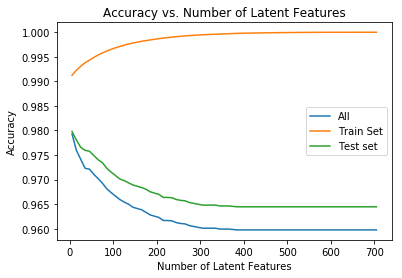

In [77]:
plt.plot(num_latent_feat, sum_errs, label='All');
plt.plot(num_latent_feat, 1 - (np.array(sum_train_errs)/(user_item_train.shape[0]*user_item_train.shape[1])), label='Train Set');
plt.plot(num_latent_feat, 1 - (np.array(sum_test_errs)/(user_item_test.shape[0]*user_item_test.shape[1])), label='Test set');

plt.legend(loc='best')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.show()


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

We notice that the accuracy on the training data increases as the number of latent features grows. However, when we look at the testing data, the accuracy is plummiting as the number of latent features increases. 

This is a sign of overfitting, meaning that we have too many features and not a big enough dataset, so our recommendations may fit the training data very well, but they fail to generalize to new data. A solution to this would be to  reduce the number of features we use. 

Since the size of our sample is very small, we cannot understand how well our predictions are performing using solely SVD. Therefore, I would conduct an A/B testing on the website, where the A group would see the old version of the site (newest articles suggested first) and the B group the articles suggested by our recommendation system. 

We can split the users using cookie based diversion on the homepage. Our invariant metric could be the number of cookies assigned to each group, and our evaluation metric the rate of clicks on recommended articles divided by the number of cookies. Then we can calculate the time that we need to run the experiment and check for statistical significance when the experiment is over in order to help us decide if our recommendation system is an improvement to how users currently find articles in the IBM Watson Studio platform.






In [78]:
# create a .html version of this notebook
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0